# Lab 13 Solution - Explainability

This week, we have seen an introduction to several explainability methods, used for peeking into the black-box of your neural network model and seeing what your model finds important while making predictions. Building upon last week's topics on fairness, this lecture on explainability is especially relevant to the ethical concerns of modeling human data. 

In our lecture demo, we have seen at two different classes of AI explainability: global surrogate models (estimating the whole black box) with **Partial Dependence Plots (PDP)** and local surrogate models (explaining one instance's prediction) with **LIME**. We now want to examine whether these explanations align with each other. 

The question we aim to answer with this lab:   
> If we run a sample of local explanations on a random subset of our students, does it align with the global explanations for our model? 

If you use noto for this notebook, don't forget to use the **Tensorflow** kernel.

In [1]:
# Load standard imports for the rest of the notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

DATA_DIR = "./../../data/"

In [2]:
# Load explainability imports.
from lime import lime_tabular
import shap

# Suppress TF warnings during import
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
# Set log level to DEBUG again
tf.get_logger().setLevel('DEBUG')

In [3]:
model_name = "{}/explainability/model".format(DATA_DIR)
loaded_model = tf.keras.models.load_model(model_name)

In [4]:
features = pd.read_csv('{}/explainability/mooc_features.csv'.format(DATA_DIR))
labels = pd.read_csv('{}/explainability/mooc_labels.csv'.format(DATA_DIR))['0']

In [5]:
features.shape, labels.shape

((8679, 250), (8679,))

In [6]:
# For 8,679 students, we have 10 weeks of data with 25 features per week.

display(features)

,RegPeakTimeDayHour_InWeek1,RegPeriodicityM1_InWeek1,DelayLecture_InWeek1,TotalClicks_InWeek1,NumberOfSessions_InWeek1,TotalTimeSessions_InWeek1,AvgTimeSessions_InWeek1,StdTimeBetweenSessions_InWeek1,StdTimeSessions_InWeek1,TotalClicksWeekday_InWeek1,...,TotalTimeVideo_InWeek10,CompetencyAnticipation_InWeek10,ContentAlignment_InWeek10,ContentAnticipation_InWeek10,StudentSpeed_InWeek10,TotalClicksVideoLoad_InWeek10,AvgWatchedWeeklyProp_InWeek10,AvgReplayedWeeklyProp_InWeek10,TotalClicksVideoConati_InWeek10,FrequencyEventLoad_InWeek10
0,3.178054,1.000000e+00,-518326.0,1.0,0.0,0.0,0.000000,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
1,7.058606,3.041330e+00,-497116.5,34.0,3.0,5423.0,1807.666667,90701.5,1158.870811,26.0,...,10683.0,0.0,0.8,0.0,558.00,16.0,0.8,0.2,16.0,0.666667
2,5.703059,3.092002e+00,-481356.0,7.0,0.0,0.0,0.000000,0.0,0.000000,7.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
3,6.929695,2.435539e+00,-427158.0,20.0,2.0,4804.0,2402.000000,0.0,998.000000,12.0,...,5325.0,0.0,1.0,0.0,2074.25,16.0,1.0,0.0,16.0,0.301887
4,12.712215,1.000000e+00,-517640.0,4.0,1.0,863.0,863.000000,0.0,0.000000,4.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8674,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8675,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8676,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000
8677,0.980829,1.224647e-16,-518394.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,16.00,0.0,0.0,0.0,0.0,0.000000


In [7]:
# For our true labels, we have a pass (0) or fail (1) performance indicator. We only use these labels after obtaining model
# explanations, to try to understand how our model performs against the ground truth.

# There are 8,679 students in this MOOC course.

display(labels)

0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
8674    1.0
8675    1.0
8676    1.0
8677    1.0
8678    1.0
Name: 0, Length: 8679, dtype: float64

In [8]:
# This function returns a (NUM OF INSTANCES, 2) array of probability of pass in first column and 
# probability of failing in another column, which is the format LIME requires.
predict_fn = lambda x: np.array([[1-loaded_model.predict(x)],
                                 [loaded_model.predict(x)]]).reshape(2,-1).T

In [9]:
class_names = ['pass', 'fail']

# We initialize the LIME explainer on our training data.
explainer = lime_tabular.LimeTabularExplainer(
      training_data=np.array(features),
      feature_names=features.columns,
      class_names=class_names,
      mode='classification',
      discretize_continuous=True)

### Select a subset of students

In [10]:
# We select 10 random students as instances from our dataset to explain.

instances = range(10, 100, 10)

### Generate local explanations with LIME (for multiple students)

In [11]:
def plot_lime(exp, instance_id):
    s = 'fail' if labels[instance_id] else 'pass'
    label = exp.available_labels()[0]
    expl = exp.as_list(label=label)
    fig = plt.figure(facecolor='white')
    vals = [x[1] for x in expl]
    names = [x[0] for x in expl]
    vals.reverse()
    names.reverse()
    colors = ['green' if x > 0 else 'red' for x in vals]
    pos = np.arange(len(expl)) + .5
    plt.barh(pos, vals, align='center', color=colors)
    plt.yticks(pos, names)
    prediction = loaded_model.predict(np.array(features.iloc[instance_id]).reshape(1,250))[0][0]
    prediction = np.round(1-prediction, 2)
    print("Student #: ", instance_id)
    print("Ground Truth Model Prediction: ", 1-labels[instance_id], "-", s)
    print("Black Box Model Prediction: ", prediction, "-", 'pass' if prediction > 0.5 else 'fail')

In [12]:
def DataFrame_all(explainers,instances,real_labels):
    df=pd.DataFrame({})
    class_names=['pass', 'fail']
    dfl=[]
    for i,exp in enumerate(explainers):
        this_label=exp.available_labels()[0]
        l=[]
        l.append(("exp number",instances[i]))
        l.append(("real value",'fail' if real_labels[instances[i]] else 'pass'))
        l.extend(exp.as_list(label=this_label))
        dfl.append(dict(l))
    df=pd.concat((df, pd.DataFrame(dfl)))
    return df

In [13]:
explainers = []
for instance_id in instances:
    # This line calls our LIME explainer on a student instance.
    explainers.append(explainer.explain_instance(features.iloc[instance_id], predict_fn, num_features=10))

Student #:  10
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.39 - fail


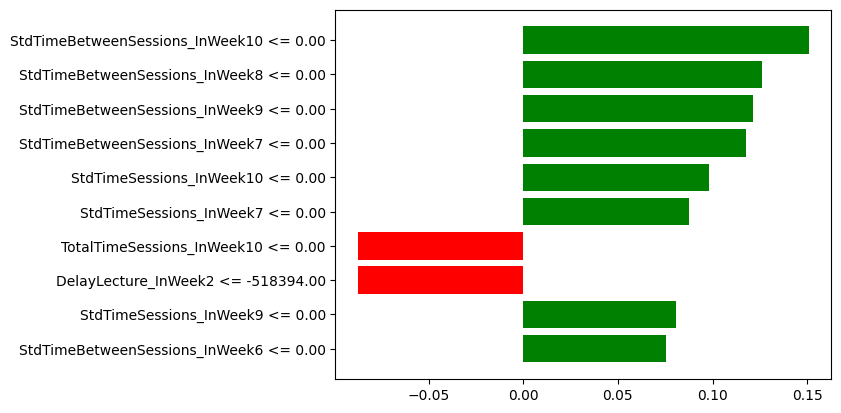

Student #:  20
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.35 - fail


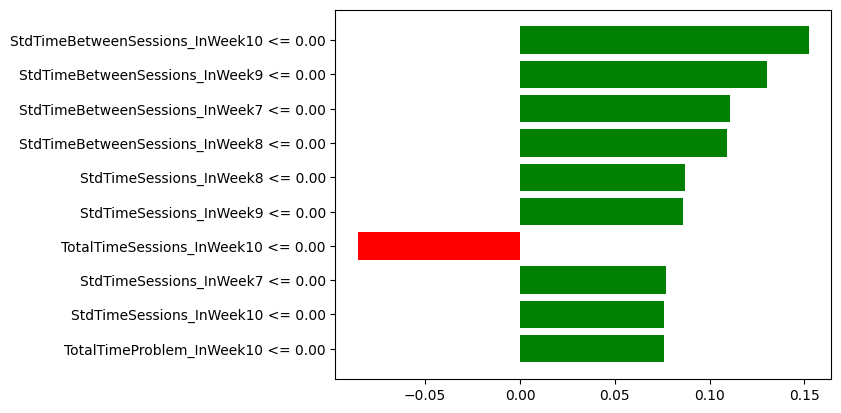

Student #:  30
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.4 - fail


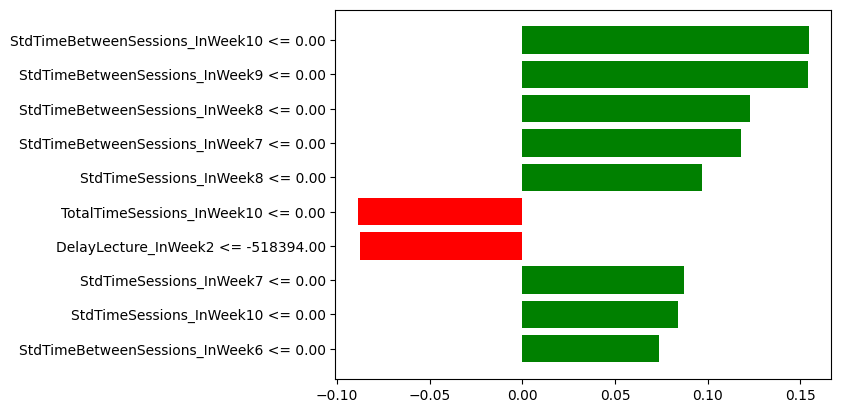

Student #:  40
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.4 - fail


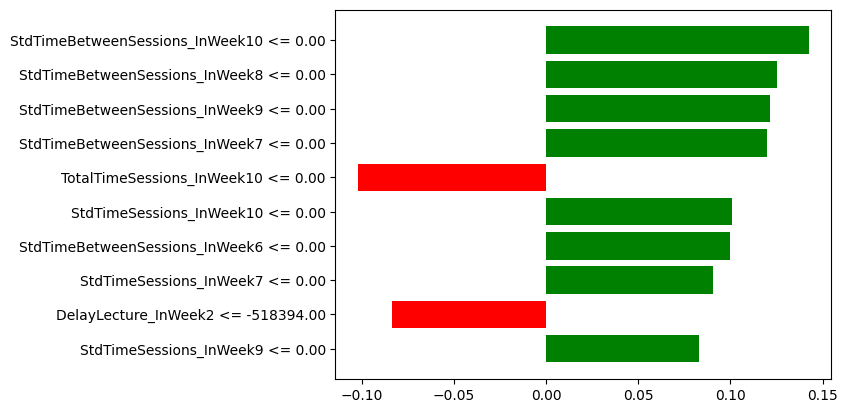

Student #:  50
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.4 - fail


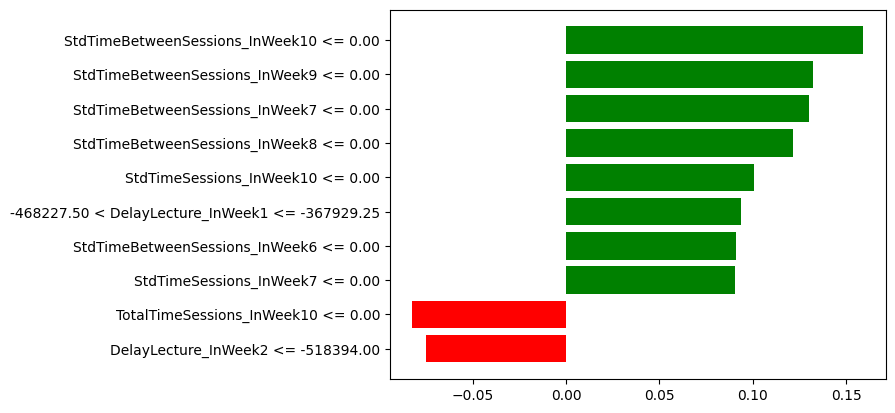

Student #:  60
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.31 - fail


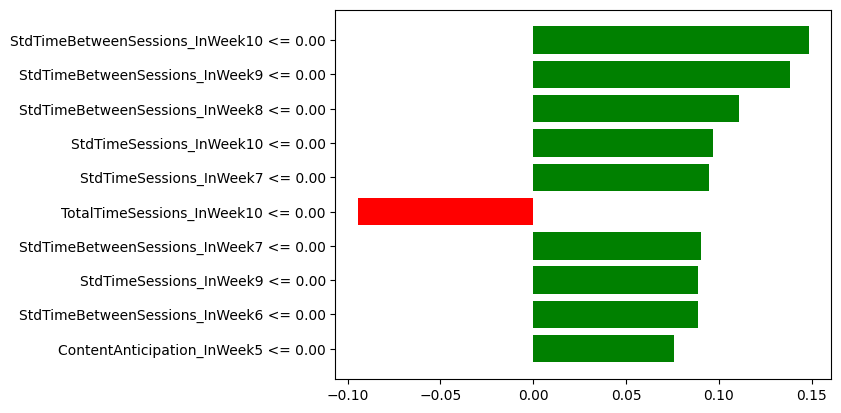

Student #:  70
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.38 - fail


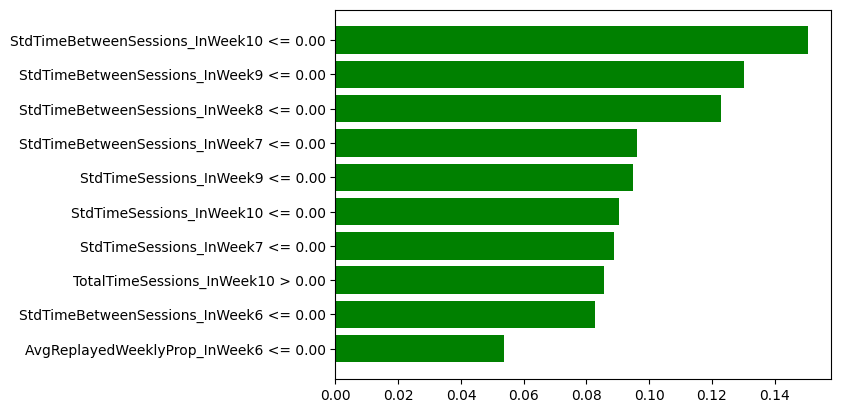

Student #:  80
Ground Truth Model Prediction:  0.0 - fail
Black Box Model Prediction:  0.38 - fail


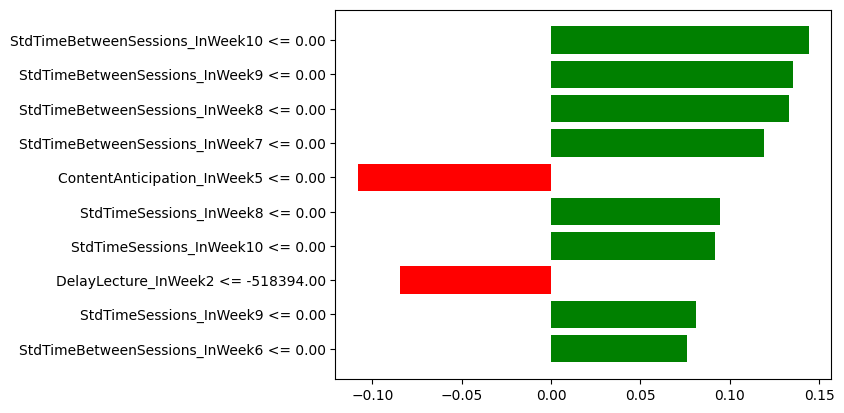

Student #:  90
Ground Truth Model Prediction:  1.0 - pass
Black Box Model Prediction:  0.31 - fail


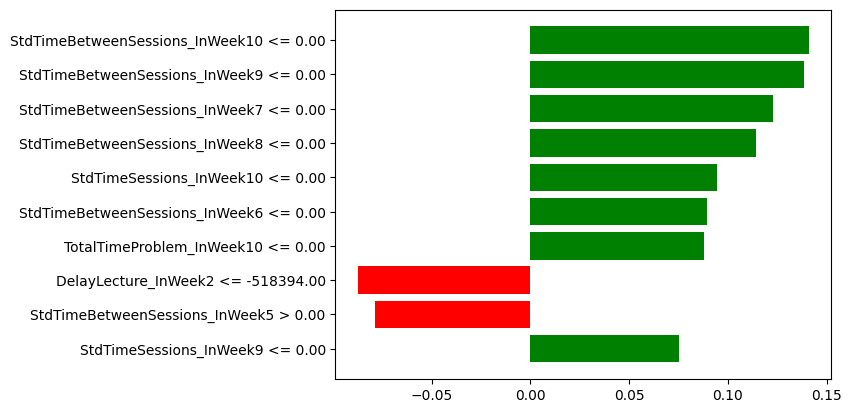

In [14]:
for exp, instance_id in zip(explainers, instances):
    plot_lime(exp, instance_id)
    plt.show()

In [15]:
# aggregate LIME feature importances (across students) into dataframe for later analysis

df = DataFrame_all(explainers,instances,labels)

In [16]:
df

,exp number,real value,StdTimeBetweenSessions_InWeek10 <= 0.00,StdTimeBetweenSessions_InWeek8 <= 0.00,StdTimeBetweenSessions_InWeek9 <= 0.00,StdTimeBetweenSessions_InWeek7 <= 0.00,StdTimeSessions_InWeek10 <= 0.00,StdTimeSessions_InWeek7 <= 0.00,TotalTimeSessions_InWeek10 <= 0.00,DelayLecture_InWeek2 <= -518394.00,StdTimeSessions_InWeek9 <= 0.00,StdTimeBetweenSessions_InWeek6 <= 0.00,StdTimeSessions_InWeek8 <= 0.00,TotalTimeProblem_InWeek10 <= 0.00,-468227.50 < DelayLecture_InWeek1 <= -367929.25,ContentAnticipation_InWeek5 <= 0.00,TotalTimeSessions_InWeek10 > 0.00,AvgReplayedWeeklyProp_InWeek6 <= 0.00,StdTimeBetweenSessions_InWeek5 > 0.00
0,10,pass,0.150923,0.126338,0.121119,0.117679,0.098031,0.087427,-0.087278,-0.087077,0.080462,0.075370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20,fail,0.152395,0.109334,0.130033,0.110975,0.075733,0.076877,-0.085394,NaN,0.086216,NaN,0.087222,0.075704,NaN,NaN,NaN,NaN,NaN
2,30,fail,0.154577,0.122779,0.153992,0.117917,0.083868,0.087141,-0.088555,-0.087496,NaN,0.073993,0.096822,NaN,NaN,NaN,NaN,NaN,NaN
3,40,fail,0.142618,0.125340,0.121347,0.119601,0.100853,0.090338,-0.102021,-0.083523,0.083167,0.100059,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50,fail,0.159107,0.121358,0.132354,0.129841,0.100829,0.090613,-0.082264,-0.075243,NaN,0.090900,NaN,NaN,0.093482,NaN,NaN,NaN,NaN
5,60,fail,0.148449,0.110948,0.138386,0.090478,0.096831,0.094840,-0.094360,NaN,0.088659,0.088641,NaN,NaN,NaN,0.075763,NaN,NaN,NaN
6,70,fail,0.150597,0.122806,0.130208,0.095982,0.090394,0.088851,NaN,NaN,0.094751,0.082641,NaN,NaN,NaN,NaN,0.085568,0.053681,NaN
7,80,fail,0.144249,0.133345,0.135314,0.119371,0.091452,NaN,NaN,-0.084579,0.081167,0.076269,0.094555,NaN,NaN,-0.108007,NaN,NaN,NaN
8,90,pass,0.141011,0.114114,0.138561,0.122756,0.094477,NaN,NaN,-0.087317,0.075152,0.089556,NaN,0.087920,NaN,NaN,NaN,NaN,-0.078919


### Generate global explanations with PDP

In [17]:
# We generate the PDP plot against a background distribution of all the points available in the feature set.
# While a minimal background distribution would let us run this analysis faster (i.e. 300 points), we recommend 
# plotting with a much larger point distribution (all the students) if you use this in other situations for 
# improved accuracy and a more global understanding of your model's behavior.

background_distribution = features

In [18]:
# This function converts our data to the right format for the PDP explainer.

predict_fn = lambda x: (1 - loaded_model.predict(x)).flatten()

In [19]:
# Based on the above analysis, select at least two features to analyze with PDP.

features_to_analyze = ['StdTimeBetweenSessions_InWeek10', 'TotalTimeSessions_InWeek10']

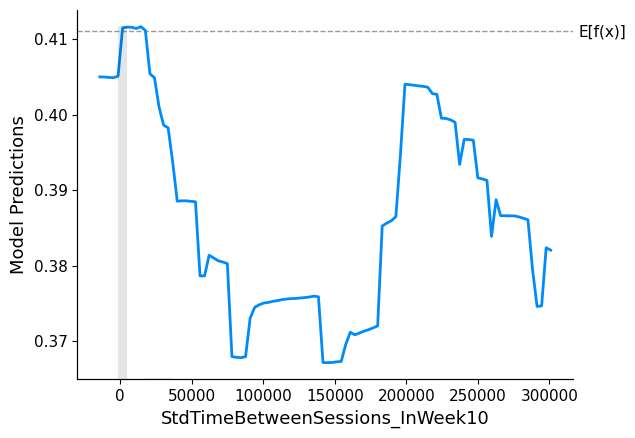

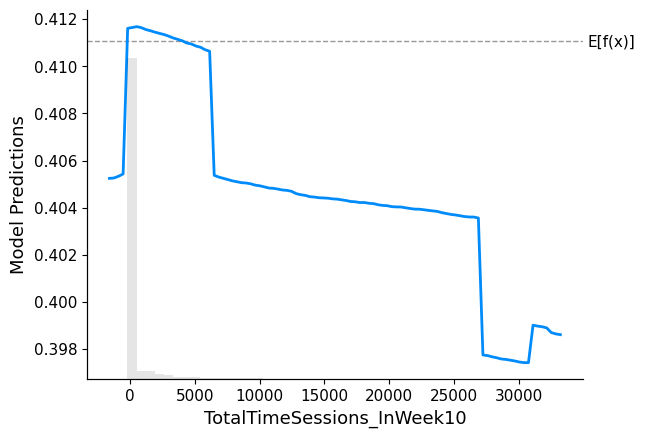

In [20]:
for feature in features_to_analyze:
    feat = list(features.columns).index(feature) 
    # Create a partial dependence plot from the background distribution.
    fig = shap.plots.partial_dependence(
      feat, predict_fn, background_distribution, ice=False, ylabel='Model Predictions',
      model_expected_value=True, feature_expected_value=False, show=True
    )

### Comparing Global and Local Explanations

Choose two features selected as important by the LIME explanations and interpret the PDP plot. Do the LIME explanations' important features correspond with the PDP analysis of that feature?

**TotalTimeProblem_InWeek10**

**StdTimeBetweenSessions_InWeek10**

We can see in both of these cases that a peak at both features at 0 is important for predicting student success.

This often refers to students who have not had session interactions or solved problems at certain weeks. 

We can infer that the model thinks that students who do nothing in week 10 are likely to fail and students who do a lot at week 10 have varying predictions (by analyzing the PDP plot in more detail). According to the PDP plot, there is a strong peak at 0, which tells us that this information applies to a lot of students.

In this way, both the LIME and PDP explanations are aligned.